In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

In [19]:
df_flickr = pd.read_csv('blip2_flickr_results.csv')
df_flickr = df_flickr.dropna(axis = 1, how = 'all')

with pd.option_context('display.max_rows', 10):
    display(df_flickr)


,txt_r1,txt_r5,txt_r10,txt_r_mean,img_r1,img_r5,img_r10,img_r_mean,r_mean,agg_metrics,...,qformer_front_blocks,qformer_middle_blocks,qformer_end_blocks,qformer_self_attn,qformer_cross_attn,qformer_text_ff,qformer_img_ff,qformer_weight_bits,Quantized Portion,weight_bits
0,0.0,0.0,0.4,0.133333,0.10,0.34,0.72,0.386667,0.260000,0.133333,...,True,False,False,False,False,True,False,2.0,ViT + Q-Former,2.0
1,0.0,0.1,0.3,0.133333,0.06,0.22,0.56,0.280000,0.206667,0.133333,...,True,False,False,False,False,True,False,2.0,Q-Former,2.0
2,0.0,0.2,0.2,0.133333,0.14,0.30,0.72,0.386667,0.260000,0.133333,...,True,False,True,False,False,True,False,2.0,Q-Former,2.0
3,0.0,0.3,0.4,0.233333,0.14,0.42,0.62,0.393333,0.313333,0.233333,...,True,False,False,True,True,True,False,2.0,ViT + Q-Former,2.0
4,0.0,0.3,0.7,0.333333,0.16,0.60,1.08,0.613333,0.473333,0.333333,...,False,True,False,True,True,True,False,2.0,ViT + Q-Former,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,98.0,100.0,100.0,99.333333,88.12,97.88,98.82,94.940000,97.136667,99.333333,...,False,True,False,False,False,False,False,2.0,ViT + Q-Former,2.0
948,98.0,100.0,100.0,99.333333,88.12,97.88,98.82,94.940000,97.136667,99.333333,...,False,False,False,False,False,False,False,NaN,ViT,2.0
949,98.0,100.0,100.0,99.333333,89.60,98.10,98.96,95.553333,97.443333,99.333333,...,True,True,True,True,True,False,True,4.0,Q-Former,4.0
950,98.0,100.0,100.0,99.333333,89.66,98.10,98.92,95.560000,97.446667,99.333333,...,False,True,True,True,True,False,True,4.0,Q-Former,4.0


In [20]:
df_flickr.columns

Index(['txt_r1', 'txt_r5', 'txt_r10', 'txt_r_mean', 'img_r1', 'img_r5',
       'img_r10', 'img_r_mean', 'r_mean', 'agg_metrics', 'model_size',
       'visual_encoder_block_modules', 'visual_encoder_block_indices',
       'visual_encoder_block_weight_bits', 'qformer_layer_indices',
       'qformer_self_attention_modules', 'qformer_self_attention_weight_bits',
       'qformer_cross_attention_modules',
       'qformer_cross_attention_weight_bits', 'qformer_text_ff_modules',
       'qformer_text_ff_weight_bits', 'qformer_img_ff_modules',
       'qformer_img_ff_weight_bits', 'job_batch', 'vit_attn', 'vit_ff',
       'vit_front_blocks', 'vit_middle_blocks', 'vit_end_blocks',
       'vit_weight_bits', 'qformer_front_blocks', 'qformer_middle_blocks',
       'qformer_end_blocks', 'qformer_self_attn', 'qformer_cross_attn',
       'qformer_text_ff', 'qformer_img_ff', 'qformer_weight_bits',
       'Quantized Portion', 'weight_bits'],
      dtype='object')

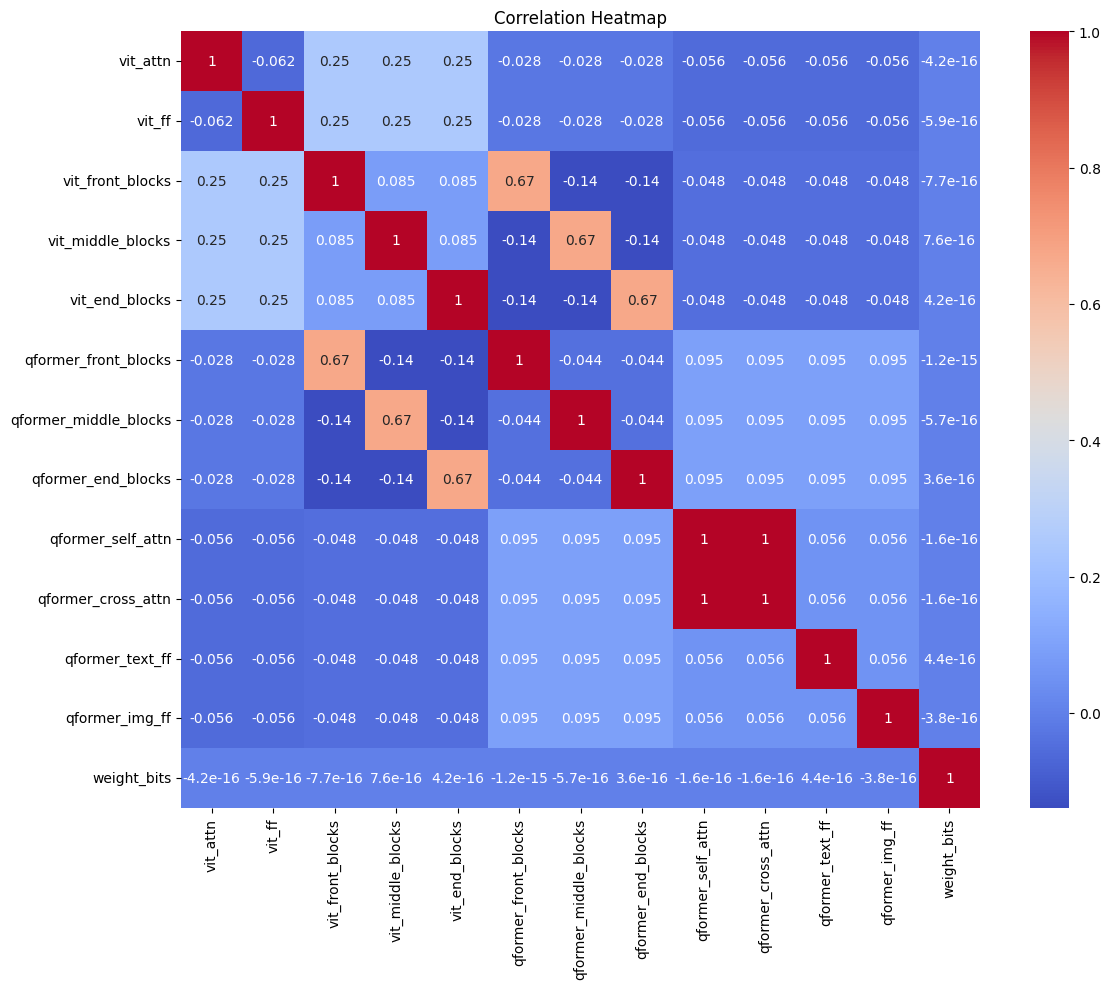

In [54]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

feature_names = ['vit_attn', 'vit_ff',
                    'vit_front_blocks', 'vit_middle_blocks', 'vit_end_blocks',
                    'qformer_front_blocks', 'qformer_middle_blocks',
                    'qformer_end_blocks', 'qformer_self_attn', 'qformer_cross_attn',
                    'qformer_text_ff', 'qformer_img_ff', 'weight_bits']

X = df_flickr[feature_names]
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X).correlation

corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])

# fig.colorbar(neg, ax=ax2, location='right', anchor=(0, 0.3), shrink=0.7)

# _ = fig.tight_layout()
# plt.show()

In [46]:
# adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
def plot_feature_importance(target_col):
    
    feature_names = ['vit_attn', 'vit_ff',
                  'vit_front_blocks', 'vit_middle_blocks', 'vit_end_blocks',
                  'qformer_front_blocks', 'qformer_middle_blocks',
                  'qformer_end_blocks', 'qformer_self_attn',
                  'qformer_text_ff', 'qformer_img_ff', 'weight_bits']


    X = df_flickr[feature_names]
    X = X.values

    Y = df_flickr[target_col]
    Y = Y.values

    RF = RandomForestRegressor(random_state = 42)
    RF.fit(X,Y)
    print(f"RF train accuracy: {RF.score(X, Y):.3f}")

    df_results = pd.DataFrame(X, columns=feature_names)
    df_results['Y'] = Y
    df_results['Y_hat'] = RF.predict(X)

    sns.scatterplot(df_results, x = 'Y', y = 'Y_hat')
    plt.title(f'RandomForestRegressor Performance on {target_col}')
    plt.show()

    # Mean Decrease in Impurity Feature Importance
    mdi_importances = pd.Series(
        RF[-1].feature_importances_, index=feature_names
    ).sort_values(ascending=True)

    ax = mdi_importances.plot.barh()
    ax.set_title(f"Random Forest Feature Importances (MDI) for {target_col}")
    ax.figure.tight_layout()
    plt.show()

    # Permutation Feature Importance
    result = permutation_importance(
        RF, X, Y, n_repeats=10, random_state=42, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    sorted_importances_idx
    feature_names = np.array(feature_names)
    
    importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx],
    )

    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Random Forest Permutation Feature Importances for {target_col}")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

    plt.show()

RF train accuracy: 1.000


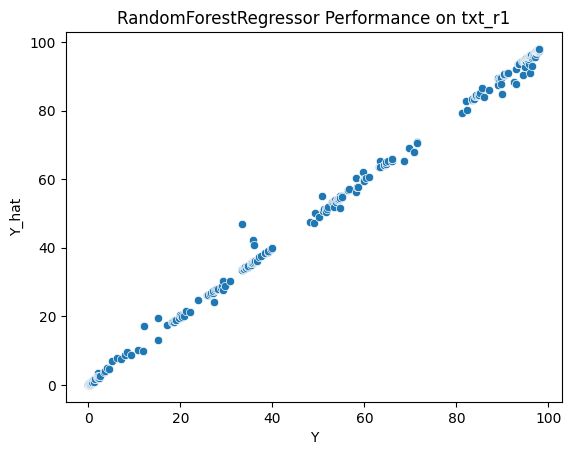

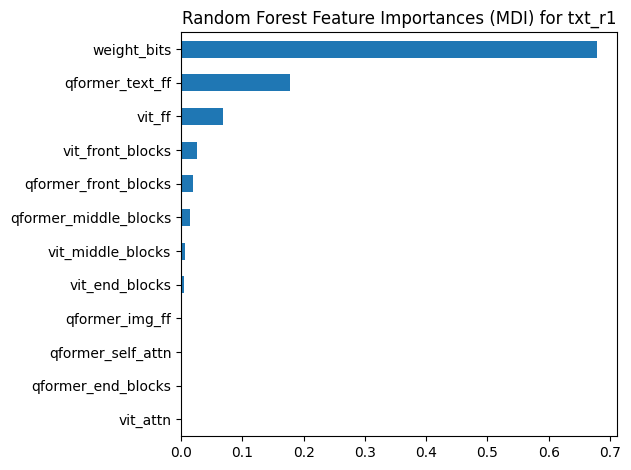

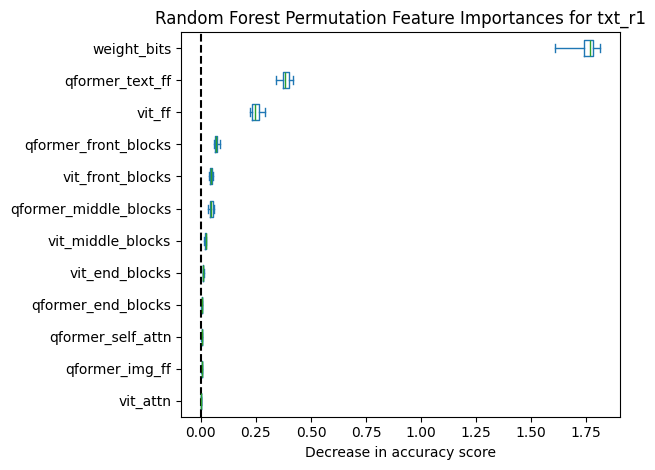

In [47]:
plot_feature_importance('txt_r1')

RF train accuracy: 1.000


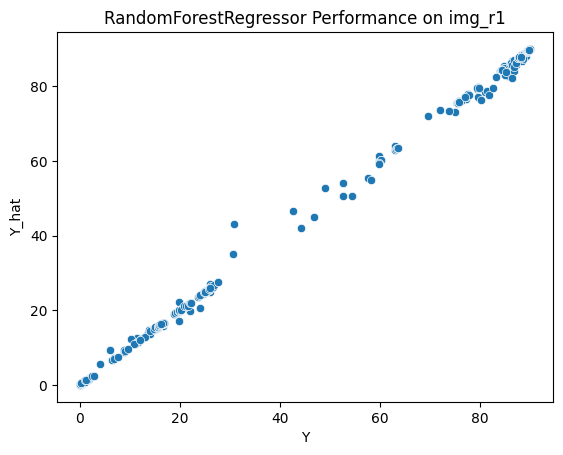

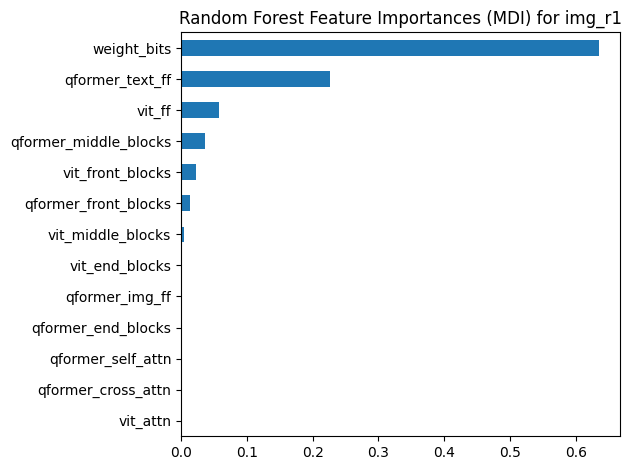

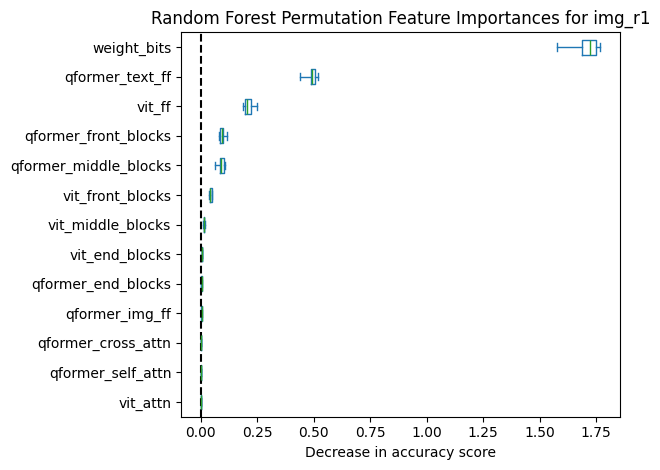

In [36]:
plot_feature_importance('img_r1')